In [54]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [55]:
M = 300 #number of random walkers
R = np.zeros((2*M,3))
for m in range(2*M):
    for d in range(3):
        R[m,d] = np.random.uniform(-0.5, 0.5)

In [56]:
def greens_function(config, old_config, alpha, beta, kappa, gamma, delta_t):
    norm_diff = np.linalg.norm(config - old_config)
    return (1/np.sqrt(4*np.pi* gamma*delta_t)) * np.exp(-norm_diff**2 / (4*gamma*delta_t))

In [57]:
def psi_T(vec_r_1, vec_r_2, alpha, kappa, beta):
    r_1 = np.linalg.norm(vec_r_1)
    r_2 = np.linalg.norm(vec_r_2)
    vec_r12 = vec_r_2 - vec_r_1
    r_12 = np.linalg.norm(vec_r12)
    pref = beta*r_12/(1+alpha*r_12)
    psi = np.exp(-kappa*(r_1+r_2))*np.exp(pref)
    return psi

def Fokker_planck(vec_r_1, vec_r_2, alpha, kappa, beta):
    r_1 = np.linalg.norm(vec_r_1)
    r_2 = np.linalg.norm(vec_r_2)
    vec_r12 = vec_r_2 - vec_r_1
    r_12 = np.linalg.norm(vec_r12)
    u = 1 + alpha*r_12
    factor = beta*(((u/r_12)-alpha)/u**2)
    force_1 = 2*(-kappa*(vec_r_1/r_1)+factor*(vec_r_1-vec_r_2))
    force_2 = 2*(-kappa*(vec_r_2/r_2)+factor*(vec_r_2-vec_r_1))
    return np.array([force_1, force_2])

def metropolis_algorithm(initial_state, num_trials, s, alpha, beta, kappa):
    sequence_states = [initial_state]
    for n in tqdm(range(num_trials)):
        next_sequence = metropolis_step(sequence_states[-1], alpha, beta, s, kappa)
        sequence_states.append(next_sequence)
    return np.array(sequence_states)
    
def metropolis_step(current_state, alpha, beta, s, kappa, use_FP = False):
    trial_configuration = current_state.copy()
    current_r_1 = current_state[:M]
    current_r_2 = current_state[M:]

    which_particle = np.random.choice([0,M])
    for i in range(M):
        #if use_FP:
        #    trial_configuration[i+which_particle] += Fokker_planck(current_r_1, current_r_2, alpha, kappa = 2, beta = 0.5)*delta_t/2
        trial_configuration[i+which_particle] += np.random.uniform(low=-s/2, high=s/2, size=3)#*np.sqrt(delta_t)
    trial_r_1 = trial_configuration[:M]
    trial_r_2 = trial_configuration[M:]
    if not use_FP:
        trial_acceptance_prob = np.min([1, (psi_T(trial_r_1, trial_r_2, alpha, kappa, beta)/psi_T(current_r_1, current_r_2, alpha, kappa, beta))**2])
    r_accept = np.random.rand()
    if r_accept < trial_acceptance_prob:
        new_state = trial_configuration
    else:
        new_state = current_state
    return np.array(new_state)


In [58]:
def energy_local(vec_r_1, vec_r_2, alpha, beta, kappa):
    r_1 = np.linalg.norm(vec_r_1)
    r_2 = np.linalg.norm(vec_r_2)
    vec_r12 = vec_r_2 - vec_r_1
    r_12 = np.linalg.norm(vec_r12)
    u = 1+alpha*r_12
    scalar_product = np.dot((vec_r_1/r_1) - (vec_r_2/r_2), vec_r12/r_12)
    E_L = (kappa-2)/r_1 + (kappa-2)/r_2 + (1-2*beta/u**2) +2*beta*alpha/u**3 - kappa**2 - (beta**2)/u**4 +(kappa*beta/u**2)*scalar_product
    return E_L

def energy_statistics(simulation, accumulate_last_n):
    energies = []
    for time in tqdm(range(N+1)):
        energies_t = []
        for i in range(M):
            e_i = energy_local(simulation[time,i], simulation[time,i+M], alpha=0.15, beta=0.5, kappa=2)
            energies_t.append(e_i)
        energies.append(energies_t)
    e_avg = np.average(energies, axis=1)
    var_E = np.std(energies, axis=1)   
    e_avg_accumulated = []
    e_var_accumulated = []
    for time in range(N+1):
        try:
            e_avg_t = np.sum([e_avg[time-accumulate_last_n:time]]) 
            e_var_t = np.sum([var_E[time-accumulate_last_n:time]])
        except: #For the first 999 time steps:
            e_avg_t = np.sum(e_avg[:time])
            e_var_t = np.sum(var_E[:time])
        e_avg_accumulated.append(e_avg_t)
        e_var_accumulated.append(e_var_t)
    return np.array(e_avg_accumulated), np.array(e_var_accumulated)

In [59]:
N = 30000
n = 1000
list_s = [0.1,1,10]

E_avg = []
E_std = []

for s_test in list_s:
    print(f"s = {s_test}:")
    simulation_s = metropolis_algorithm(R, N, s_test, alpha=0.15, beta=0.5, kappa=2)
    E_avg_s, E_std_s = energy_statistics(simulation_s, n)
    E_avg.append(E_avg_s)
    E_std.append(E_std_s)

s = 0.1:


100%|██████████| 30001/30001 [01:37<00:00, 306.46it/s]


s = 1:


100%|██████████| 30001/30001 [01:38<00:00, 305.86it/s]


s = 10:


100%|██████████| 30001/30001 [01:39<00:00, 302.48it/s]


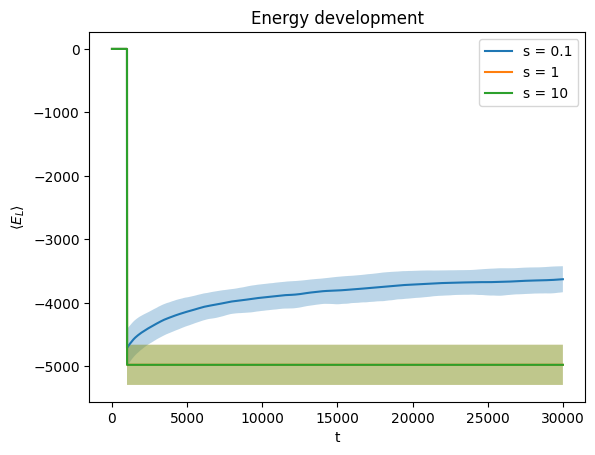

In [60]:
t = np.arange(N+1)
for i in range(len(E_avg)):
    plt.fill_between(t, E_avg[i]-E_std[i], E_avg[i]+E_std[i], alpha=0.3)
    plt.plot(t, E_avg[i], label=f"s = {list_s[i]}")
    
plt.title("Energy development")
plt.xlabel("t")
plt.ylabel(r"$\langle E_L \rangle$")
plt.legend()